<a href="https://colab.research.google.com/github/FNS-Division/geopython-2025/blob/main/3_fiber_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fiber path modeling

## Setting up our environment

In this section, we import the necessary Python libraries for our fiber path modeling:

Data handling tools (`pandas`, `numpy`) for efficient data manipulation
Network analysis tools (`networkx`) for creating and analyzing network graphs
Spatial libraries (`geopandas`, `scipy`) for geographic calculations
Visualization tools (`matplotlib`, `folium`) for displaying our results
Additional utilities for improved functionality

In [1]:
!pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 25.2 MB/s eta 0:00:00


In [2]:
# Data handling
import pandas as pd
import numpy as np

# Efficient queueing and combinations
import heapq
import itertools

# Graph and spatial libraries
import networkx as nx
import geopandas as gpd
from scipy.spatial import cKDTree

# Visualization
import matplotlib.pyplot as plt
import folium

# Miscellaneous utilities
from tqdm import tqdm
import pycountry

# Notebook interaction and display
import ipywidgets as widgets
from IPython.display import display

## Set analysis parameters

Here we create an interactive interface that allows us to:

- Select a country from a dropdown menu
- Set the maximum fiber length use to connect each point of interest

These parameters will influence how our network is constructed and how schools can be connected to fiber nodes. You need to click play button of the controls cell each time you change the parameters.

In [3]:
#@title
# Define the layout for the input fields
item_layout = widgets.Layout(
    width='auto',
    min_width='20px',
    flex='1 1 auto',
    display='flex',
    flex_flow='row wrap',
    align_items='center',
    justify_content='space-between'
)

item_layout2 = widgets.Layout(
    width='auto',
    min_width='20px',
    flex='1 1',
    display='flex',
    flex_flow='row wrap',
    align_items='center',
    justify_content='space-between'
)

# Create the input fields
country = widgets.Dropdown(
    description='Country:',
    options=list(map(lambda x: x.name, pycountry.countries)),
    value='Sao Tome and Principe',
    layout=item_layout2,
    style={'description_width': 'initial'}
)

maximum_connection_length = widgets.FloatSlider(
    description='Maximum Connection Length (km):',
    min=0,
    max=100,
    step=1,
    value=15,
    layout=item_layout,
    style={'description_width': 'initial'}
)

# Create a container to hold the input fields
inputs_layout = widgets.VBox(
    children=[
        widgets.HBox([country], layout=widgets.Layout(justify_content='space-between')),
        widgets.HBox([maximum_connection_length], layout=widgets.Layout(justify_content='space-between')),
    ]
)

# Display the input fields
display(inputs_layout)

## Download school dataset

We load data about school locations in Algeria. Each school is represented by:

- Geographic coordinates (latitude and longitude)
- Unique identifiers
- Additional metadata

We convert this into a GeoDataFrame to enable spatial operations.

In [4]:
schools_gdf = gpd.read_file("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/stp/standardized/schools.geojson")
schools_gdf = schools_gdf[["poi_id","dataset_id","lat","lon","geometry"]]
schools_gdf = schools_gdf.rename(columns={"poi_id":"id"}, inplace=False)
schools_gdf["label"] = "unconnected_school"

In [5]:
schools_gdf.head()

,id,dataset_id,lat,lon,geometry,label
0,db86aaf7-d436-4870-ab5b-d86a5d4cbac2,a325c91c-5ccf-4194-85b9-541cf7fc3f7c,0.256797,6.742431,POINT (6.74243 0.2568),unconnected_school
1,f33dfd17-d046-44ea-b1a3-d86972329e34,a325c91c-5ccf-4194-85b9-541cf7fc3f7c,0.260252,6.741389,POINT (6.74139 0.26025),unconnected_school
2,5cb57a0e-cda6-4d89-9ab9-9f2263bf6d30,a325c91c-5ccf-4194-85b9-541cf7fc3f7c,0.247277,6.737467,POINT (6.73747 0.24728),unconnected_school
3,51e14794-c870-4c8f-a52c-adbdfbec4acf,a325c91c-5ccf-4194-85b9-541cf7fc3f7c,0.263945,6.743357,POINT (6.74336 0.26394),unconnected_school
4,e7ebc158-ccc2-4834-b6f4-dbf7d6edf24d,a325c91c-5ccf-4194-85b9-541cf7fc3f7c,0.339996,6.738550,POINT (6.73855 0.34),unconnected_school


## Download transmission node dataset

Similar to the school dataset, we load information about fiber transmission nodes. These are the existing connection points in our network that schools can potentially connect to.

In [6]:
fiber_nodes_gdf = gpd.read_file("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/stp/standardized/fiber_nodes.geojson")
fiber_nodes_gdf = fiber_nodes_gdf
fiber_nodes_gdf = fiber_nodes_gdf.rename(columns={"ict_id":"id"}, inplace=False)
fiber_nodes_gdf["label"] = "fiber_node"

In [7]:
fiber_nodes_gdf.head()

,id,dataset_id,lat,lon,operator_name,infrastructure_type,node_status,equipped_capacity_mbps,potential_capacity_mbps,geometry,label
0,728ba7b0-64e1-4969-a6af-4e561304169f,27833e92-2d4c-4f04-af78-7c1575f937bd,1.6779,7.3801,<NA>,fiber,operational,<NA>,<NA>,POINT (7.3801 1.6779),fiber_node
1,3e0989a5-193a-43ff-b261-19a9b35da900,27833e92-2d4c-4f04-af78-7c1575f937bd,1.6724,7.3801,<NA>,fiber,operational,<NA>,<NA>,POINT (7.3801 1.6724),fiber_node
2,5bb48f06-b29d-4da4-a130-fded88d31b9f,27833e92-2d4c-4f04-af78-7c1575f937bd,1.6724,7.3856,<NA>,fiber,operational,<NA>,<NA>,POINT (7.3856 1.6724),fiber_node
3,28d3e8b2-f215-4421-b201-7e57f3d7e0d4,27833e92-2d4c-4f04-af78-7c1575f937bd,1.6724,7.4130,<NA>,fiber,operational,<NA>,<NA>,POINT (7.413 1.6724),fiber_node
4,a91e0b66-90e5-4afb-863b-97f24492a55c,27833e92-2d4c-4f04-af78-7c1575f937bd,1.6669,7.4130,<NA>,fiber,operational,<NA>,<NA>,POINT (7.413 1.6669),fiber_node


## Combine both datasets

We merge the school and fiber node datasets into a single DataFrame. This combined dataset will form the basis of our network analysis, containing both potential connection points (transmission nodes) and locations needing connection (schools).

In [8]:
df_locations = pd.concat([schools_gdf, fiber_nodes_gdf]).set_index('id')

# Re-project
utm = df_locations.estimate_utm_crs()
df_locations = df_locations.to_crs(utm)

## Define connected and unconnected points

In [9]:
connected_idx = df_locations.loc[df_locations.label != 'unconnected_school'].index
unconnected_idx = df_locations.loc[df_locations.label == 'unconnected_school'].index

In [10]:
assert len(connected_idx) > 0, "There are no fiber nodes in the selected area"
assert len(unconnected_idx) > 0, "There are no schools in the selected area"

## Create line of sight (LOS) graph

This is where we build our network model:

- The `haversine` function calculates distances between points on Earth's surface
- The `generate_all_index_pairs` function creates possible connections between locations
- The `create_line_of_sight_graph` function builds a network graph where:
    - Nodes represent schools and fiber points
    - Edges represent possible connections
    - Edge weights are distances in meters

In [11]:
# @title Function
def distance_matrix(gdf, upper_tri=False):
    """Calculate distance matrix between geometries in a GeoDataFrame using the .distance method.

    Args:
        gdf (GeoDataFrame): Input GeoDataFrame containing the geometries
        upper_tri (bool, optional): If True, returns only upper triangular part of distance matrix.
                                  Defaults to False.

    Returns:
        ndarray: Distance matrix where element [i,j] is the distance between geometry i and j.
                If upper_tri=True, returns flattened upper triangular part only.
                Units match the input GeoDataFrame's CRS.

    Note:
        For geographic calculations (lat/lon), the GeoDataFrame should be projected first.
        The distance calculation uses the .distance method which assumes a planar/projected surface.
    """
    # Compute distances
    distances = [[geom1.distance(geom2) for geom2 in gdf.geometry]
                for geom1 in gdf.geometry]
    distances = np.array(distances)

    # Return only upper triangular part if requested
    if upper_tri:
        i_upper = np.triu_indices(distances.shape[0], k=1)
        distances = distances[i_upper]

    return distances

def generate_all_index_pairs(vals):
    """Generate all possible pairs of indices from a list of values.

    Creates unique combinations of indices without repetition and without order
    (i.e., (a,b) but not (b,a)).

    Args:
        vals (list): List of values to generate pairs from

    Returns:
        tuple: Two lists containing paired indices (origin_nodes, destination_nodes)
    """
    # Generate unique pairs using itertools.combinations
    # This ensures no duplicate pairs and no self-pairs
    index_pairs = itertools.combinations(vals, 2)

    # Split pairs into separate lists for origin and destination
    orig_nodes, dest_nodes = zip(*index_pairs)

    return orig_nodes, dest_nodes

def create_line_of_sight_graph(locations):
    """Create a graph representing line-of-sight connections between locations.

    Builds an undirected graph where edges represent potential connections between
    locations, weighted by their geodesic distances.

    Args:
        locations (DataFrame): DataFrame containing 'lat' and 'lon' columns

    Returns:
        networkx.Graph: Undirected graph with weighted edges representing distances
    """
    # Get all possible pairs of location indices
    orig_nodes, dest_nodes = generate_all_index_pairs(locations.index)

    # Calculate distances in meters
    distances = distance_matrix(locations, upper_tri=True)

    # Create undirected graph and add weighted edges
    graph = nx.Graph()
    graph.add_weighted_edges_from(zip(orig_nodes, dest_nodes, distances))

    return graph

def draw_graph_with_connected_nodes(graph, connected, figsize=(10, 10)):
    """Visualize network graph with highlighted connected nodes.

    Creates a visualization where nodes are colored based on their connection status
    and includes a legend for node types.

    Args:
        graph (networkx.Graph): Network graph to visualize
        connected (set or list): Nodes that are connected/transmission nodes
        figsize (tuple, optional): Figure size. Defaults to (10, 10)
    """
    plt.figure(figsize=figsize)

    # Calculate spring layout for node positions
    pos = nx.spring_layout(graph)

    # Ensure connected is a set for efficient lookup
    connected = set(connected) if not isinstance(connected, set) else connected

    # Color nodes based on connection status
    node_colors = ['red' if node in connected else 'skyblue' for node in graph.nodes()]

    # Draw the network
    nx.draw(graph,
           pos=pos,
           with_labels=False,
           node_size=300,
           node_color=node_colors,
           font_size=10,
           font_color='black',
           edge_color='gray')

    # Create and add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w',
                   label='Transmission Node', markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w',
                   label='School', markerfacecolor='skyblue', markersize=10)
    ]

    plt.legend(handles=legend_elements, loc='upper right')
    plt.title("Line of Sight Graph with Connected Nodes")
    plt.show()

In [12]:
graph = create_line_of_sight_graph(df_locations)

In [13]:
# Inspect a node in the graph
list(graph.nodes(data=True))[0]

('db86aaf7-d436-4870-ab5b-d86a5d4cbac2', {})

In [14]:
# Inspect an edge in the graph
list(graph.edges(data=True))[0]

('db86aaf7-d436-4870-ab5b-d86a5d4cbac2',
 'f33dfd17-d046-44ea-b1a3-d86972329e34',
 {'weight': 399.34917045820555})

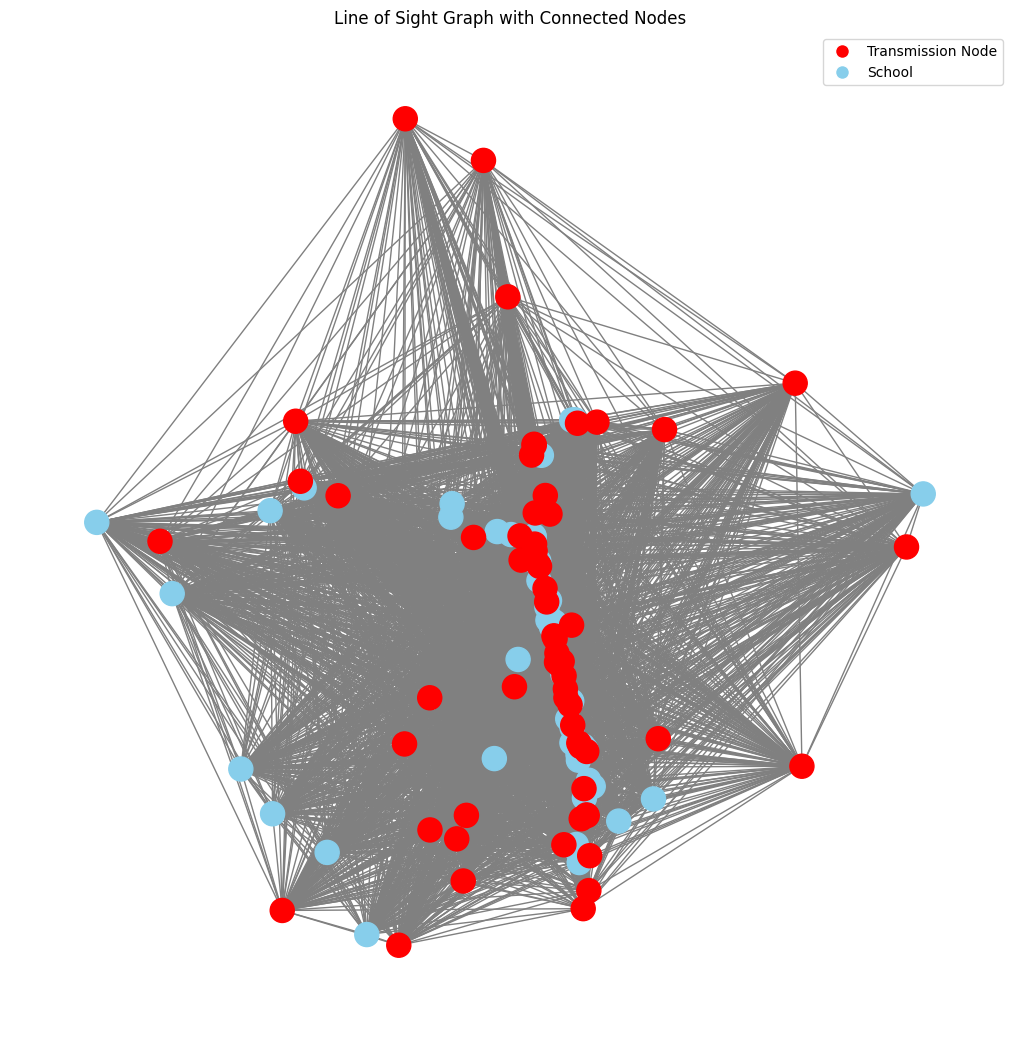

In [15]:
draw_graph_with_connected_nodes(graph, connected_idx)

If we were using a graph based on the road network instead of straight lines, we could initialize our graph in the following way. Road graphs can be extracted from OpenStreetMap using the `osmnx` library.

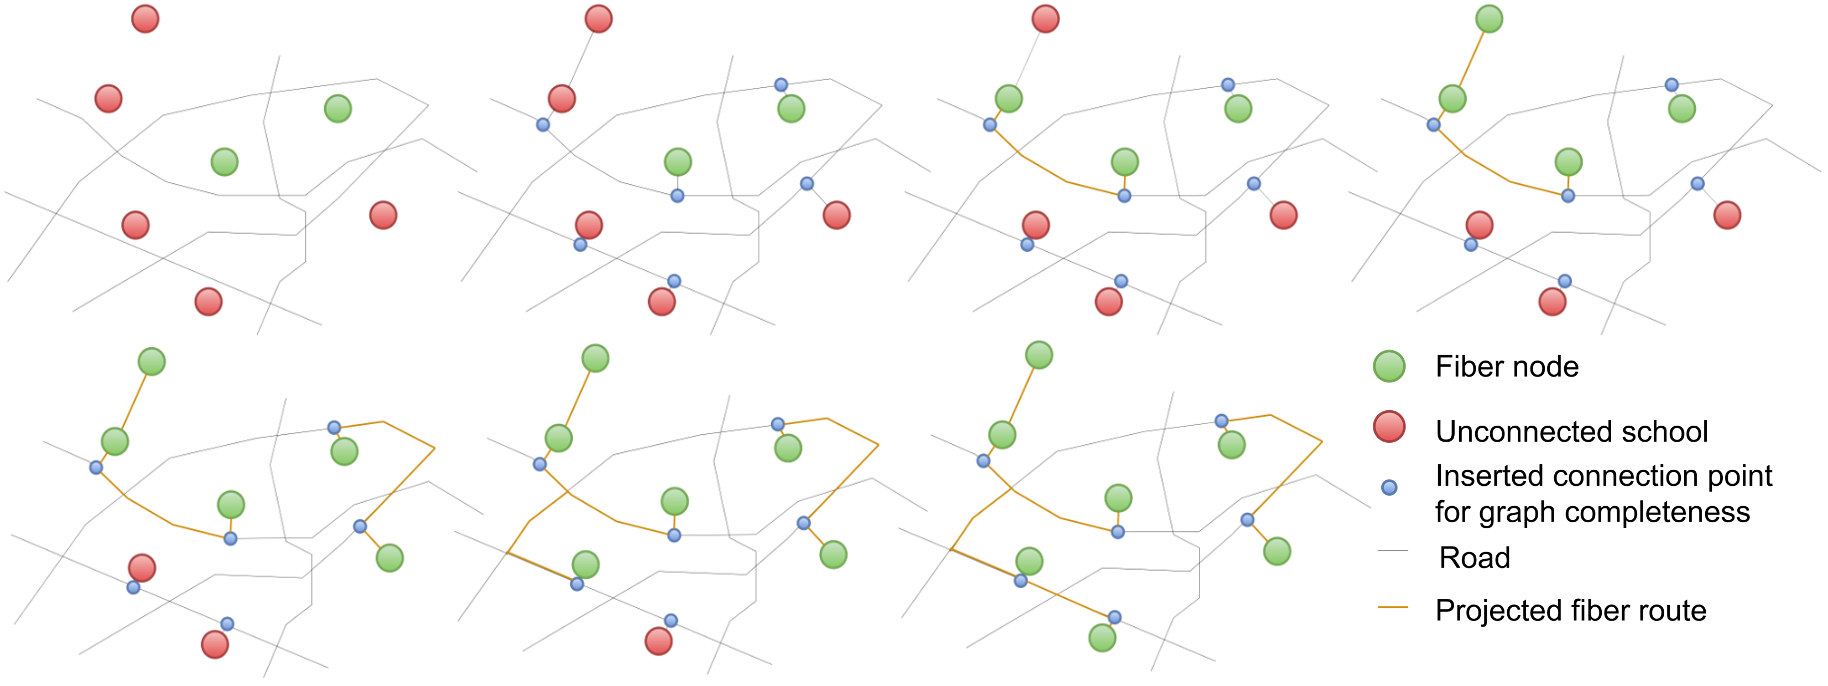

## Connect unconnected schools

This section implements the core algorithm for connecting schools to the fiber network:

1. Identifies the closest transmission node for each school
2. Uses a priority queue to process connections in order of shortest distance
3. Iteratively builds connections while respecting maximum distance constraints
4. Tracks the path and distance information for each connection

In [16]:
# @title Algorithm
def connect_schools(locations, connected_idx, max_connection_length, graph_, scale_economies=True):
    """
    Connects unconnected schools to the nearest connected school dynamically using the given graph.
    Returns a DataFrame containing the fiber path information for each school.

    Args:
        locations : DataFrame of all locations where the index is the location identifier.
        connected_idx: List of indices that are either fiber nodes or points connected with fiber.
        max_connection_length: Maximum length of cable that can be used to connect an unconnected location.
        graph_ : Networkx graph object representing the line of sight graph.
        scale_economies: If True, the algorithm will enable connected schools to act as fiber nodes to extend the connection.

    Returns:
        fiber_path_df (DataFrame): DataFrame containing the fiber path and other information for each school that is connected to the network.
        connected_idx (set): Updated set of connected school indices after connection.
    """

    # Copy the list of connected indices and initialize sets of connected and unconnected indices
    connected_idx_cache = connected_idx
    connected_idx = set(connected_idx)
    unconnected_idx = set(locations.index) - connected_idx
    initial_unconnected = len(unconnected_idx)

    # Generate pairs of unconnected and connected node indices for shortest path calculations
    ind = itertools.product(unconnected_idx, connected_idx)
    orig_nodes, dest_nodes = zip(*ind)

    # Calculate shortest path lengths between each unconnected and connected node
    sp_lengths = []
    print("Calculating shortest path lengths...")
    for orig_node, dest_node in tqdm(zip(orig_nodes, dest_nodes), total=len(orig_nodes)):
        sp_lengths.append(nx.shortest_path_length(graph_, orig_node, dest_node, weight='weight'))

    # Reshape distances into a matrix to find the closest connected node for each unconnected school
    dist_to_connected = np.array(sp_lengths).reshape(len(unconnected_idx), len(connected_idx))
    closest_connected_id = connected_idx_cache[np.argmin(dist_to_connected, axis=1)]
    closest_connected_distance = np.min(dist_to_connected, axis=1)

    # Create a dictionary to store fiber path information for each school
    fiber_path_dict = dict.fromkeys(locations.index)

    # Initialize fiber path data for schools that are already connected
    fiber_path_dict.update({idx: dict(
                                closest_node_id=idx,
                                closest_node_distance=0,
                                connected_node_id=idx,
                                connected_node_distance=0,
                                fiber_path=[]
                            ) for idx in connected_idx})

    # Initialize path information for unconnected schools with nearest connected node details
    fiber_path_dict.update([(idx, dict(
                                closest_node_id=closest_connected_id[i],
                                closest_node_distance=closest_connected_distance[i],
                                connected_node_id='',
                                connected_node_distance=0,
                                fiber_path=[]
                            )) for i, idx in enumerate(unconnected_idx)])

    # Initialize a priority queue to hold possible connections below the maximum cable length
    queue = []
    for d_ in zip(sp_lengths, orig_nodes, dest_nodes):
        if d_[0] <= max_connection_length:
            heapq.heappush(queue, d_)

    # Main loop to iteratively connect each unconnected school to the network
    print("Connecting schools...")

    # Initialize progress bar for connected schools
    with tqdm(total=len(unconnected_idx), desc="Schools Connected") as pbar:
        while queue:
            # Get the shortest valid connection from the priority queue
            min_dist, min_node, upstream_node = heapq.heappop(queue)

            # If the node is already connected, skip to the next
            if min_node in connected_idx:
                continue

            # If the connection is within the allowed distance, add it to the connected set
            if min_dist <= max_connection_length:
                connected_idx.add(min_node)
                unconnected_idx.remove(min_node)

                # Update fiber path information for the newly connected node
                fiber_path_dict[min_node].update(
                    connected_node_id=fiber_path_dict[upstream_node]['connected_node_id'],
                    connected_node_distance=nx.shortest_path_length(graph_, min_node, upstream_node, weight='weight') + fiber_path_dict[upstream_node]['connected_node_distance'],
                    upstream_node_id=upstream_node,
                    upstream_node_distance=min_dist,
                    fiber_path=fiber_path_dict[upstream_node]['fiber_path'] + [upstream_node]
                )

                # Update the progress bar
                pbar.update(1)

                # Exit if all schools are connected
                if len(unconnected_idx) == 0:
                    break

                # Only process new connections if scale_economies is True
                if scale_economies:
                    # Generate new connections from the newly connected node to remaining unconnected schools
                    ind = itertools.product(unconnected_idx, [min_node])
                    orig_nodes, dest_nodes = zip(*ind)

                    # Calculate shortest path lengths for new possible connections
                    new_sp_lengths = []
                    for orig_node, dest_node in zip(orig_nodes, dest_nodes):
                        new_sp_lengths.append(nx.shortest_path_length(graph_, orig_node, dest_node, weight='weight'))

                    # Add new valid connections to the priority queue
                    for d_ in zip(new_sp_lengths, orig_nodes, dest_nodes):
                        if d_[0] <= max_connection_length:
                            heapq.heappush(queue, d_)

    # Convert the fiber path dictionary to a DataFrame for easy handling
    fiber_path_df = pd.DataFrame(fiber_path_dict.values(), index=fiber_path_dict.keys())
    return fiber_path_df, connected_idx

In [17]:
fiber_path_df, fiber_path_connected_idx = connect_schools(df_locations, connected_idx, maximum_connection_length.value * 1000, graph, scale_economies=True)

Calculating shortest path lengths...


100%|██████████| 3087/3087 [00:27<00:00, 113.61it/s]


Connecting schools...


Schools Connected: 100%|██████████| 49/49 [00:05<00:00,  8.78it/s]


In [18]:
fiber_path_df.head(10)

,closest_node_id,closest_node_distance,connected_node_id,connected_node_distance,fiber_path,upstream_node_id,upstream_node_distance
db86aaf7-d436-4870-ab5b-d86a5d4cbac2,565289e2-6a74-4e5e-94c7-247f224c10c5,946.539475,0963fc64-62b1-4bfe-a738-262865573bb8,1495.340218,"[0963fc64-62b1-4bfe-a738-262865573bb8, 1fd0775...",f33dfd17-d046-44ea-b1a3-d86972329e34,399.349170
f33dfd17-d046-44ea-b1a3-d86972329e34,83009abf-c1cc-4729-9cef-8b854ceeff97,1035.402712,0963fc64-62b1-4bfe-a738-262865573bb8,1095.991048,"[0963fc64-62b1-4bfe-a738-262865573bb8, 1fd0775...",51e14794-c870-4c8f-a52c-adbdfbec4acf,463.585462
5cb57a0e-cda6-4d89-9ab9-9f2263bf6d30,565289e2-6a74-4e5e-94c7-247f224c10c5,290.220461,85e16072-6b76-4c36-916b-c8f199b2c0ed,290.310988,"[85e16072-6b76-4c36-916b-c8f199b2c0ed, 6b9934a...",6b9934aa-e988-41f8-8edb-f90db08829c5,0.305246
51e14794-c870-4c8f-a52c-adbdfbec4acf,83009abf-c1cc-4729-9cef-8b854ceeff97,623.813683,0963fc64-62b1-4bfe-a738-262865573bb8,632.405585,"[0963fc64-62b1-4bfe-a738-262865573bb8, 1fd0775...",1fd0775a-4c9f-447c-bb2c-f94424485522,13.087960
e7ebc158-ccc2-4834-b6f4-dbf7d6edf24d,fff9f044-495e-4b9c-9d34-c7693a5b947f,274.619576,7eec7057-6877-4406-81f4-e97e7e09da42,283.000877,"[7eec7057-6877-4406-81f4-e97e7e09da42, 0a41685...",0a416855-72ac-4e9d-8463-1953b2ebd4b7,34.579591
48cad1ae-d0b3-43b4-a5e9-0ca0bfc22082,728ba7b0-64e1-4969-a6af-4e561304169f,241.044440,af744033-e990-407a-9d19-6cb3a28baf81,376.414193,"[af744033-e990-407a-9d19-6cb3a28baf81, 9bb27fc...",9bb27fcd-cae2-43a6-9437-1025f1d31066,178.328128
0358d033-0500-49f4-a330-5067767bd460,2a02b5cd-3d65-4a61-a8a6-bcdc41ccc60a,279.042356,b68a08b4-7b27-497f-b658-267c8276d9f8,506.851077,"[b68a08b4-7b27-497f-b658-267c8276d9f8, 943b700...",943b7008-55d1-468f-ba88-4586989a24b8,278.179837
ab583861-5947-4962-99ad-3a1de1781f49,c1520e63-38d7-402f-8f07-a4109960d1ac,97.387018,b24e6f7e-7e80-416a-b568-5c8f7425233c,97.387018,[b24e6f7e-7e80-416a-b568-5c8f7425233c],b24e6f7e-7e80-416a-b568-5c8f7425233c,97.387018
c7a17b26-f287-404b-8adb-41791856b8b9,4bc5ad88-67c7-4600-ad83-c589bdbe9624,879.160317,a0bdc402-200c-46e4-bd06-e6757ffd7c35,879.160317,[a0bdc402-200c-46e4-bd06-e6757ffd7c35],a0bdc402-200c-46e4-bd06-e6757ffd7c35,879.160317
5f8c412a-1a6a-4560-8186-4f238a5df56b,11c54980-bd75-44a9-9550-f0f1ebfe70ee,292.002100,c1520e63-38d7-402f-8f07-a4109960d1ac,292.002100,[c1520e63-38d7-402f-8f07-a4109960d1ac],c1520e63-38d7-402f-8f07-a4109960d1ac,292.002100


## Visualise the fiber path solution

Finally, we create an interactive map visualization showing the connections made by the algorithm.

In [19]:
# @title Function
def create_simple_network_map(locations, df_results):
    # Create map
    m = folium.Map(
        location=[locations['lat'].mean(), locations['lon'].mean()],
        zoom_start=14
    )

    # Add points and connections
    for idx, row in locations.iterrows():
        color = 'red' if row['label'] == 'unconnected_school' else 'blue'
        folium.CircleMarker([row['lat'], row['lon']],
                          radius=5,
                          color=color,
                          fill=True).add_to(m)

    for _, row in df_results.iterrows():
        if not np.isnan(row.get('upstream_node_distance', np.nan)):
            source_loc = locations.loc[row.name]
            target_loc = locations.loc[row['upstream_node_id']]
            folium.PolyLine([[source_loc['lat'], source_loc['lon']],
                            [target_loc['lat'], target_loc['lon']]],
                           color='purple',
                           weight=2).add_to(m)

    # Add legend with colored symbols
    legend = """
    <div style="
        position: absolute;
        top: 10px;
        right: 10px;
        z-index: 9999;
        background-color: white;
        padding: 10px;
        border: 2px solid black;
        border-radius: 5px;
        ">
        <div><span style="color:red">●</span> Unconnected Schools</div>
        <div><span style="color:blue">●</span> Fiber Nodes</div>
        <div><span style="color:purple">━</span> Connections</div>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend))

    return m

In [20]:
map_viz = create_simple_network_map(df_locations, fiber_path_df)
map_viz

If using the road network instead of straight lines, the solution would look something like this.

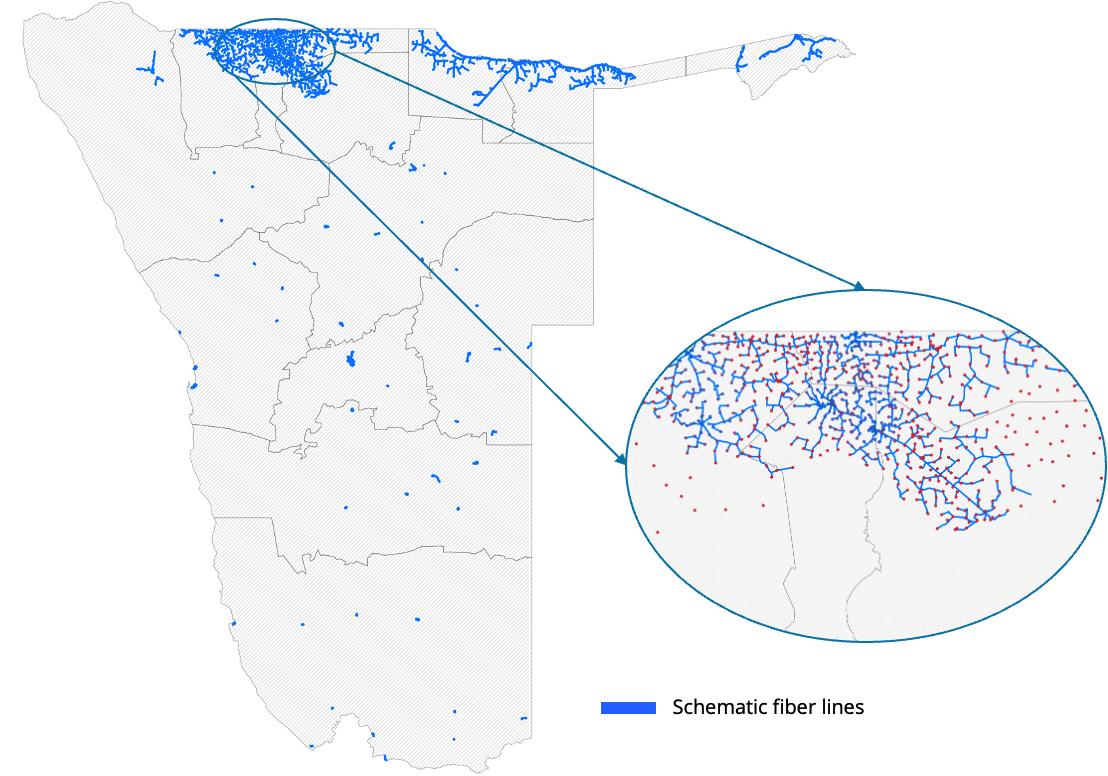